In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils

def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    #  identify and localize objects or regions of interest within the image.
    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    
    return new_img

if __name__ == "__main__":
    dataset_dir = "brainTumor"  # Root directory of the dataset
    IMG_SIZE = 256

    # Loop through training and testing directories
    for folder in ['training', 'testing']:
        folder_path = os.path.join(dataset_dir, folder)
        class_folders = os.listdir(folder_path)
        
        # Loop through tumor and notumor folders
        for class_folder in class_folders:
            class_path = os.path.join(folder_path, class_folder)
            save_path = os.path.join('cleaned', folder, class_folder)
            
            # Create directory if it doesn't exist
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            
            # Loop through images in the class folder
            for img_name in tqdm(os.listdir(class_path)):
                img_path = os.path.join(class_path, img_name)
                image = cv2.imread(img_path)
                
                if image is not None:
                    new_img = crop_img(image)
                    new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))
                    cv2.imwrite(os.path.join(save_path, img_name), new_img)


In [11]:
import os
import numpy as np
from skimage.feature import hog
from skimage import exposure
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import cv2
import seaborn as sns
import imutils
import plotly.graph_objs as go
from plotly.offline import iplot

In [28]:
def load_data(directory, use_hog=True):
    images = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                if use_hog:
                    # Extract HOG features
                    hog_features = hog(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2))

                    images.append(hog_features)
                # else:
                #     images.append(image.flatten())  # Flatten the image array
                labels.append(class_folder)
    num_features = len(hog_features)
    print("Number of features:", num_features)
    return np.array(images), np.array(labels)

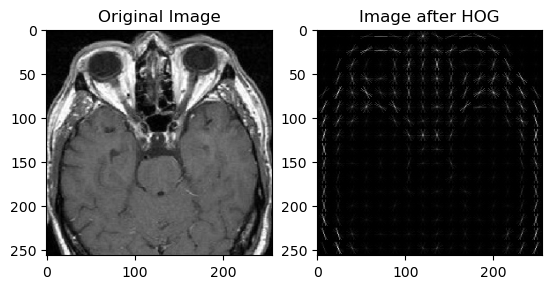

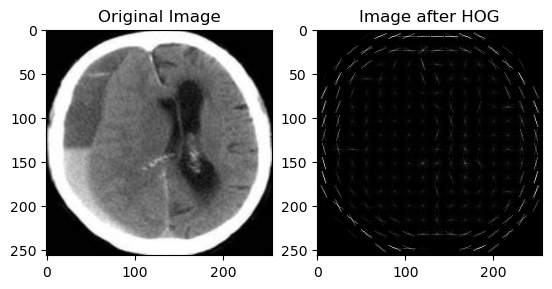

In [4]:
def display_images(directory):
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        img_names = os.listdir(class_path)
        if len(img_names) > 0:
            img_path = os.path.join(class_path, img_names[0])
            original_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if original_image is not None:
                # original image
                plt.figure()
                plt.subplot(1, 2, 1)
                plt.imshow(original_image, cmap='gray')
                plt.title('Original Image')
                
                # hog
                hog_features, hog_image = hog(original_image, visualize=True, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
                
                # after hog
                plt.subplot(1, 2, 2)
                plt.imshow(hog_image, cmap='gray')
                plt.title('Image after HOG')
                
                plt.show()
                break  


display_images('cleaned/training')
display_images('cleaned/testing')


In [29]:
cleaned_dir = 'cleaned'

# Load training and testing data with HOG feature extraction
X_train, y_train = load_data(os.path.join(cleaned_dir, 'training'), use_hog=True)
X_test, y_test = load_data(os.path.join(cleaned_dir, 'testing'), use_hog=True)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Number of features: 8100
Number of features: 8100


In [27]:
# Count occurrences of 'tumor' and 'notumor' classes in each set
class_counts = {'Train Set': {'tumor': np.sum(y_train == 'tumor'), 'notumor': np.sum(y_train == 'notumor')},
                'Validation Set': {'tumor': np.sum(y_val == 'tumor'), 'notumor': np.sum(y_val == 'notumor')},
                'Test Set': {'tumor': np.sum(y_test == 'tumor'), 'notumor': np.sum(y_test == 'notumor')}}

# Plotting the counts using Plotly
colors = ['#ff3300', '#33cc33']  # Colors for 'notumor' and 'tumor'
data = [go.Bar(x=list(class_counts[set_name].keys()), y=list(class_counts[set_name].values()), name=set_name, 
               marker=dict(color=colors)) for set_name, colors in zip(['Train Set', 'Validation Set', 'Test Set'], colors)]

layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Class'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data=data, layout=layout)
fig.show()

In [5]:
print(y_train.shape,X_train.shape,y_test.shape,X_test.shape)

(2347,) (2347, 8100) (711,) (711, 8100)


In [10]:
# Linear kernel
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

# Polynomial kernel (degree=2)
svm_poly2 = SVC(kernel='poly', degree=2)
svm_poly2.fit(X_train, y_train)

# Polynomial kernel (degree=3)
svm_poly3 = SVC(kernel='poly', degree=3)
svm_poly3.fit(X_train, y_train)

# RBF kernel (default parameters)
svm_rbf_default = SVC(kernel='rbf')
svm_rbf_default.fit(X_train, y_train)

# RBF kernel (gamma=0.1)
svm_rbf_gamma01 = SVC(kernel='rbf', gamma=0.1)
svm_rbf_gamma01.fit(X_train, y_train)

# Sigmoid kernel (default parameters)
svm_sigmoid_default = SVC(kernel='sigmoid')
svm_sigmoid_default.fit(X_train, y_train)

# Sigmoid kernel (gamma=0.1)
svm_sigmoid_gamma01 = SVC(kernel='sigmoid', gamma=0.1)
svm_sigmoid_gamma01.fit(X_train, y_train)

SVC(gamma=0.1, kernel='sigmoid')

sigmoid
-------
Training Accuracy: 0.9037068598210481
Mean Cross-Validation Accuracy: 0.9595
Standard Deviation of Cross-Validation Accuracy: 0.0094
Validation Accuracy: 0.9625212947189097
Test Accuracy: 0.9831223628691983
----------------------------------------------------------
rbf
----
Training Accuracy: 0.9931827865360034
Mean Cross-Validation Accuracy: 0.9578
Standard Deviation of Cross-Validation Accuracy: 0.0074
Validation Accuracy: 0.9608177172061328
Test Accuracy: 0.9662447257383966
-----------------------------------------------------------
poly2
------
Training Accuracy: 0.9995739241585002
Mean Cross-Validation Accuracy: 0.9638
Standard Deviation of Cross-Validation Accuracy: 0.0074
Validation Accuracy: 0.9659284497444633
Test Accuracy: 0.980309423347398
--------------------------------------------------------------
poly3
------
Training Accuracy: 1.0
Mean Cross-Validation Accuracy: 0.9629
Standard Deviation of Cross-Validation Accuracy: 0.0088
Validation Accuracy: 0.9642248722316865
Test Accuracy: 0.9817158931082982
------------------------------------------------------------
linear
------
Training Accuracy: 1.0
Mean Cross-Validation Accuracy: 0.9595
Standard Deviation of Cross-Validation Accuracy: 0.0094
Validation Accuracy: 0.9625212947189097
Test Accuracy: 0.9831223628691983
---------------------------------------------------------

In [6]:


svm = SVC(kernel='poly', degree=2)
svm.fit(X_train, y_train)

k = 9 # no folds
cv_scores = cross_val_score(svm, X_train, y_train, cv=k)



Training Accuracy: 0.9995739241585002
Mean Cross-Validation Accuracy: 0.9655
Standard Deviation of Cross-Validation Accuracy: 0.0097
Validation Accuracy: 0.9659284497444633
Test Accuracy: 0.980309423347398
Fold 1 Accuracy: 0.9808
Fold 2 Accuracy: 0.9540
Fold 3 Accuracy: 0.9617
Fold 4 Accuracy: 0.9540
Fold 5 Accuracy: 0.9617
Fold 6 Accuracy: 0.9655
Fold 7 Accuracy: 0.9579
Fold 8 Accuracy: 0.9769
Fold 9 Accuracy: 0.9769


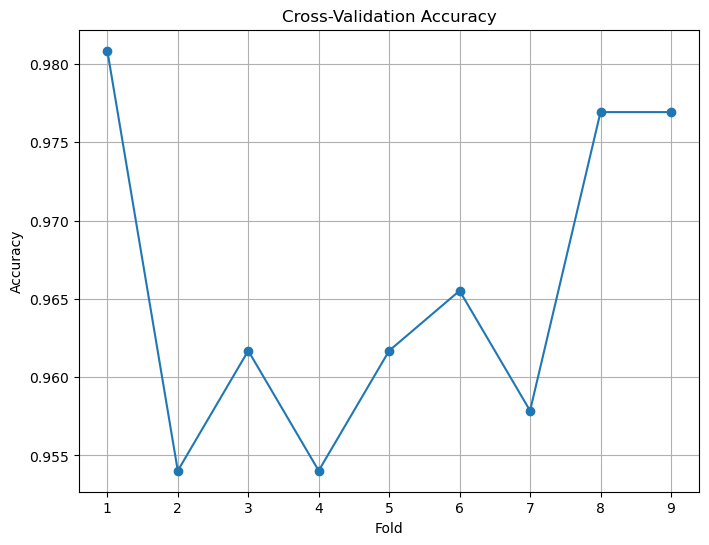

In [7]:
y_pred_train = svm.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

# Calculate mean accuracy and standard deviation of the cross-validation scores
mean_cv_accuracy = np.mean(cv_scores)
std_cv_accuracy = np.std(cv_scores)
print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy:.4f}")
print(f"Standard Deviation of Cross-Validation Accuracy: {std_cv_accuracy:.4f}")

# Calculate accuracy on validation set
y_pred_val = svm.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", validation_accuracy)

# Calculate accuracy on test set
y_pred_test = svm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)

# Calculate accuracy scores for each fold
accuracy_scores = []
for fold, score in enumerate(cv_scores, start=1):
    print(f"Fold {fold} Accuracy: {score:.4f}")
    accuracy_scores.append(score)



# Plot cross-validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, k + 1), accuracy_scores, marker='o', linestyle='-')
plt.title('Cross-Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()




Training Accuracy: 0.9995739241585002
Mean Cross-Validation Accuracy: 0.9655
Standard Deviation of Cross-Validation Accuracy: 0.0097
Validation Accuracy: 0.9659284497444633
Test Accuracy: 0.980309423347398


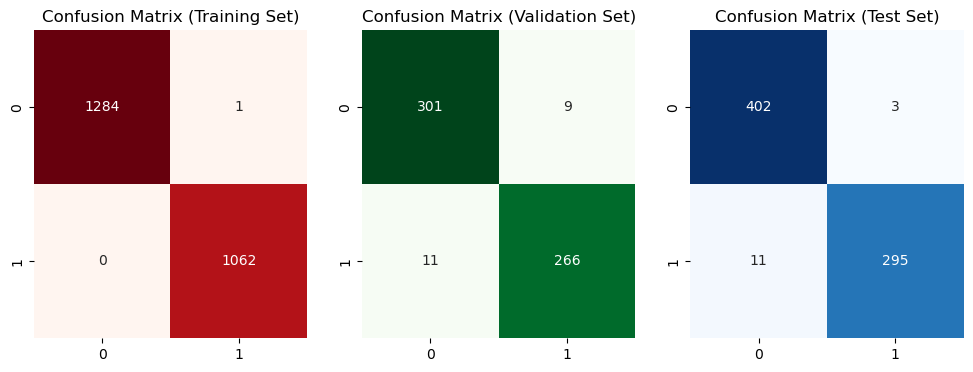

In [24]:
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_val = confusion_matrix(y_val, y_pred_val)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Print metrics
print("Training Accuracy:", train_accuracy)
print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy:.4f}")
print(f"Standard Deviation of Cross-Validation Accuracy: {std_cv_accuracy:.4f}")
print("Validation Accuracy:", validation_accuracy)
print("Test Accuracy:", test_accuracy)

# Plot confusion matrix
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Confusion Matrix (Training Set)")
sns.heatmap(conf_matrix_train, annot=True, cmap="Reds", fmt="d", cbar=False)

plt.subplot(1, 3, 2)
plt.title("Confusion Matrix (Validation Set)")
sns.heatmap(conf_matrix_val, annot=True, cmap="Greens", fmt="d", cbar=False)  

plt.subplot(1, 3, 3)
plt.title("Confusion Matrix (Test Set)")
sns.heatmap(conf_matrix_test, annot=True, cmap="Blues", fmt="d", cbar=False)  


plt.show()

In [9]:
# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_train, y_pred_train, pos_label='tumor')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_train, y_pred_train, pos_label='tumor')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_train, y_pred_train, pos_label='tumor')
print("F1-score:", f1)

Accuracy: 0.9995739241585002
Precision: 0.9990592662276576
Recall: 1.0
F1-score: 0.9995294117647059


In [10]:
# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_train, y_pred_train, pos_label='notumor')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_train, y_pred_train, pos_label='notumor')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_train, y_pred_train, pos_label='notumor')
print("F1-score:", f1)

Accuracy: 0.9995739241585002
Precision: 1.0
Recall: 0.9992217898832685
F1-score: 0.9996107434799533


In [11]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred_test, pos_label='tumor')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred_test, pos_label='tumor')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred_test, pos_label='tumor')
print("F1-score:", f1)

Accuracy: 0.980309423347398
Precision: 0.9899328859060402
Recall: 0.9640522875816994
F1-score: 0.9768211920529801


In [12]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred_test, pos_label='notumor')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred_test, pos_label='notumor')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred_test, pos_label='notumor')
print("F1-score:", f1)

Accuracy: 0.980309423347398
Precision: 0.9733656174334141
Recall: 0.9925925925925926
F1-score: 0.9828850855745721


In [13]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_val)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_val, y_pred_val, pos_label='tumor')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_val, y_pred_val, pos_label='tumor')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_val, y_pred_val, pos_label='tumor')
print("F1-score:", f1)

Accuracy: 0.9659284497444633
Precision: 0.9672727272727273
Recall: 0.9602888086642599
F1-score: 0.963768115942029


In [14]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_val)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_val, y_pred_val, pos_label='notumor')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_val, y_pred_val, pos_label='notumor')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_val, y_pred_val, pos_label='notumor')
print("F1-score:", f1)

Accuracy: 0.9659284497444633
Precision: 0.9647435897435898
Recall: 0.9709677419354839
F1-score: 0.9678456591639872


array([[[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [2, 2, 2],
        [2, 2, 2]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [3, 3, 3],
        [2, 2, 2],
        [2, 2, 2]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [4, 4, 4],
        [3, 3, 3],
        [3, 3, 3]],

       ...,

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [3, 3, 3],
        [2, 2, 2],
        [1, 1, 1]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [3, 3, 3],
        [2, 2, 2],
        [2, 2, 2]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [5, 5, 5],
        [5, 5, 5],
        [5, 5, 5]]], dtype=uint8)

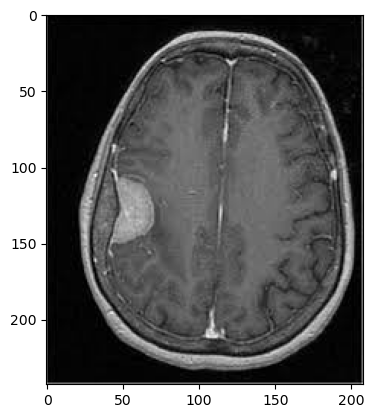

In [43]:
def crop_img(img):
  
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

   
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    
    return new_img


def preprocess_image(image_path, output_size=256):
    
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to read the image.")
        return None
    
    processed_image = crop_img(image)
    processed_image = cv2.resize(processed_image, (output_size, output_size))
    
    return processed_image



In [42]:
def predict(image_path):

    processed_image = preprocess_image(image_path)

    gray_image = cv2.cvtColor(processed_image, cv2.COLOR_RGB2GRAY)

    #HOG
    hog_features, hog_image = hog(gray_image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)

    # prdect the big big tumor
    prediction1 = svm.predict(hog_features.reshape(1,-1))

    # show me the prdection 
    if prediction1[0] == 'tumor':
        print("there is a big big tumor.")
    else:
        print("no tumor, Unfortunatlly you are gonna live a long long life.")




there is a big big tumor.


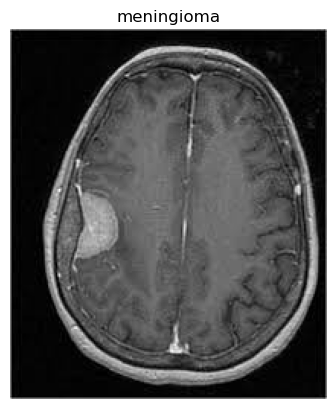

In [41]:
image_path = "brainTumor/testing/meningioma/Te-me_0079.jpg"
if(image_path):
    try:
        predict(image_path)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        TumorType = os.path.basename(os.path.dirname(image_path))

        plt.imshow(image, cmap="gray")
        plt.title(TumorType)
        plt.axis("off")
        plt.show

    except Exception as e:
        print("An error occurred:", e)

In [38]:
import sys
from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QWidget, QPushButton, QLabel, QFileDialog
from PyQt5.QtGui import QPixmap, QImage



class MainWindow(QMainWindow):
    def __init__(self, svm):
        super().__init__()

        self.setWindowTitle("Tumor Detection")
        self.setGeometry(100, 100, 800, 600)

        self.central_widget = QWidget()
        self.setCentralWidget(self.central_widget)

        layout = QVBoxLayout()
        self.central_widget.setLayout(layout)

        self.image_label = QLabel()
        layout.addWidget(self.image_label)

        self.load_button = QPushButton("Load Image")
        self.load_button.clicked.connect(self.load_image)
        layout.addWidget(self.load_button)

        self.predict_button = QPushButton("Predict")
        self.predict_button.clicked.connect(self.predict)
        layout.addWidget(self.predict_button)

        self.prediction_label = QLabel()
        layout.addWidget(self.prediction_label)
    
        # Load SVM model
        self.svm = svm
    

    def crop_img(img):
    
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), 0)

    
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        
        return new_img


    def preprocess_image(self):
        output_size=256
        processed_image = self.crop_img(self.image)
        processed_image = cv2.resize(processed_image, (output_size, output_size))
    
        return processed_image


    
        
    def load_image(self):
        file_dialog = QFileDialog()
        file_path, _ = file_dialog.getOpenFileName(self, "Open Image File", "", "Image Files (*.jpg *.png)")
        if file_path:
            self.image_path = file_path
            self.image = cv2.imread(self.image_path)
            self.display_image()

    def display_image(self):
        height, width, _ = self.image.shape
        bytes_per_line = 3 * width
        q_img = QPixmap.fromImage(QImage(self.image.data, width, height, bytes_per_line, QImage.Format_RGB888))
        self.image_label.setPixmap(q_img)

    




    def predict(self):

        if hasattr(self, 'image'):
            # preprocessed_image = self.preprocess_image(self.image)
            gray_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)
            #HOG
            hog_features, hog_image = hog(gray_image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)

            # prdect the big big tumor
            prediction1 = self.svm.predict(hog_features.reshape(1,-1))

            if prediction1[0] == 'tumor':
                result_text = "The model predicts that the image contains a tumor."
            else:
                result_text = "The model predicts that the image does not contain a tumor."
                self.prediction_label.setText(result_text)
        else:
            self.prediction_label.setText("No image loaded.")


    


if __name__ == '__main__':
    try:
        app = QApplication(sys.argv)
        window = MainWindow(svm)
        window.show()
        sys.exit(app.exec_())
    except Exception as e:
        print("An error occurred:", e)


SystemExit: 0

c:\Users\Madiha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
